In [10]:
import Pkg; Pkg.add("JLD2")
using CSV, Tables, LinearAlgebra, Random, Gurobi, JuMP, Statistics, DataFrames, JLD2

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


## Import files

In [17]:
# Station information
stations_info = CSV.read("../data/stations/station_information.csv", DataFrame);
# Capacities
C = stations_info[!, :capacity];
# Distances
D = load("../data/parameters/distances.jld2", "D");
# Feasibility
X = load("../data/parameters/feasibility.jld2", "X");
# demand
demand = load("../data/parameters/202210-demand.jld2", "demand");

## Input parameters

In [41]:
# Initial state 
y0 = floor.(C/2);
# demand over one day
# Day 1
d = demand[:,:,1:24];
# Day 10
d_2 = demand[:,:,241:264];
# Day 20
d_3 = demand[:,:,481:504];

## Problem size reduction

In [31]:
function reduce_problem(d,C,y0,D,X,nb)
    n_stations = size(d,1)
    stations_score = zeros(n_stations)
    # for each station i, sum the number of bikes that gets in an out ot the station over the month
    for i in 1:n_stations
        stations_score[i] += sum(d[i,:,:]) + sum(d[:,i,:])
    end
    # sort stations by score
    stations_score_sorted = sortperm(stations_score, rev=true);
    # reorder index of columns and rows according to the sorted stations
    d_sorted = d[stations_score_sorted, stations_score_sorted, :];
    C_sorted = C[stations_score_sorted,:];
    y0_sorted = y0[stations_score_sorted,:];
    D_sorted = D[stations_score_sorted, stations_score_sorted];
    X_sorted = X[stations_score_sorted, stations_score_sorted];
    # keep only the nb first stations
    d_new = d_sorted[1:nb,1:nb,:];
    C_new = C_sorted[1:nb,:];
    y0_new = y0_sorted[1:nb,:];
    D_new = D_sorted[1:nb,1:nb];
    X_new = X_sorted[1:nb,1:nb];
    return d_new, C_new, y0_new, D_new, X_new
end

reduce_problem (generic function with 1 method)

In [32]:
d_new, C_new, y0_new, D_new, X_new = reduce_problem(d,C,y0,D,X,200);
d_2_new, C_new, y0_new, D_new, X_new = reduce_problem(d_2,C,y0,D,X,200);
d_3_new, C_new, y0_new, D_new, X_new = reduce_problem(d_3,C,y0,D,X,200);

In [34]:
# check that it is the same
println(d[66,60,12]==d_new[2,1,12])

true


# Model

In [62]:
function solve_model(K,S,C,D,X,y0,d, lambda, n_rebal)
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "OutputFlag", 0)
    set_optimizer_attribute(model, "TimeLimit", 100)

    n_stations, _, n_hours = size(d)
    M=30

    # Decision variables
    @variable(model, x[1:n_rebal, 1:n_rebal, 1:K, 1:n_hours], Bin)
    @variable(model, 0 <= z[1:n_rebal, 1:n_rebal, 1:K, 1:n_hours], Int)
    @variable(model, 0 <= y[1:n_stations, 1:n_hours]) # Int by definition of the constraints
    @variable(model, 0 <= w[1:n_stations, 1:n_stations, 1:n_hours], Int)
    @variable(model, 0 <= u[1:n_stations, 1:n_stations, 1:n_hours])

    # Add constraints:
    # Stations capacity
    @constraint(model, [i in 1:n_stations, t in 1:n_hours], y[i,t] <= C[i])
    # No rebalancing at the same station
    @constraint(model, [i in 1:n_rebal, k in 1:K, t in 1:n_hours], x[i,i,k,t] == 0)
    # Flow balance 
    @constraint(model, [i in 1:n_rebal, t in 2:n_hours], y[i,t] - y[i,t-1] == sum(w[j,i,t] for j in 1:n_stations)-sum(w[i,j,t] for j in 1:n_stations)-sum(z[i,j,k,t] for j in 1:n_rebal, k in 1:K)+sum(z[j,i,k,t] for j in 1:n_rebal, k in 1:K))
    @constraint(model, [i in n_rebal+1:n_stations, t in 2:n_hours], y[i,t] - y[i,t-1] == sum(w[j,i,t] for j in 1:n_stations)-sum(w[i,j,t] for j in 1:n_stations))
    # Flow balance for the first hour 
    @constraint(model, [i in 1:n_rebal], y[i,1] - y0[i] == sum(w[j,i,1] for j in 1:n_stations)-sum(w[i,j,1] for j in 1:n_stations)-sum(z[i,j,k,1] for j in 1:n_rebal, k in 1:K)+sum(z[j,i,k,1] for j in 1:n_rebal, k in 1:K))
    @constraint(model, [i in n_rebal+1:n_stations], y[i,1] - y0[i] == sum(w[j,i,1] for j in 1:n_stations)-sum(w[i,j,1] for j in 1:n_stations))
    # Vans capacity
    @constraint(model, [i in 1:n_rebal, j in 1:n_rebal, k in 1:K, t in 1:n_hours], z[i,j,k,t] <= S)
    # Users travel availability
    @constraint(model, [i in 1:n_stations, t in 1:n_hours], -y[i,t] <= sum(w[j,i,t] for j in 1:n_stations) - sum(w[i,j,t] for j in 1:n_stations))
    @constraint(model, [i in 1:n_stations, t in 1:n_hours], sum(w[j,i,t] for j in 1:n_stations) - sum(w[i,j,t] for j in 1:n_stations)<= C[i] - y[i,t])
    # Max 1 rebalancing per hour per van
    @constraint(model, [k in 1:K, t in 1:n_hours], sum(x[i,j,k,t] for i in 1:n_rebal, j in 1:n_rebal) <= 1)
    # Rebalancing feasibility
    @constraint(model, [i in 1:n_rebal, j in 1:n_rebal, k in 1:K, t in 1:n_hours], z[i,j,k,t] <= M*x[i,j,k,t])
    @constraint(model, [i in 1:n_rebal, j in 1:n_rebal, k in 1:K, t in 1:n_hours], x[i,j,k,t] <= X[i,j])
    # Users travel is inferior to the d and definition of u
    @constraint(model, [i in 1:n_stations, j in 1:n_stations, t in 1:n_hours], u[i,j,t] >= d[i,j,t] - w[i,j,t])
    @constraint(model, [i in 1:n_stations, j in 1:n_stations, t in 1:n_hours], d[i,j,t] >= w[i,j,t])

    # Set objective
    @objective(model, Min, sum(u[i,j,t] for i in 1:n_stations, j in 1:n_stations, t in 1:n_hours)+lambda*sum(D[i,j]*x[i,j,k,t] for i in 1:n_rebal, j in 1:n_rebal, k in 1:K, t in 1:n_hours))
    
    # Solve the model
    optimize!(model)
    
    # Print the solution
    println("Objective value: ", objective_value(model))
    return value.(x), value.(w), value.(u), value.(y), value.(z), objective_value(model)
end

solve_model (generic function with 1 method)

### Parameters

In [81]:
# Number of vans
K=5
# Capacity of vans
S=10
# stations for rebalancing 
n_rebal = 50; # Top 50 according to station scores
# Trade-off for multi-objective
lambda=10 # to be tuned according to the objectives scales

10

## Solve for Day 1

In [82]:
x_1,w_1,u_1,y_1,z_1,obj_1=solve_model(K,S,C_new,D_new,X_new,y0_new,d_new,lambda,n_rebal);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter TimeLimit to value 100
Objective value: 931.2845325792499


In [83]:
n_stations, _, n_hours = size(d_new)
println(sum(u_1[i,j,t] for i in 1:n_stations, j in 1:n_stations, t in 1:n_hours))

825.0


In [84]:
println(sum(D_new[i,j]*x_1[i,j,k,t] for i in 1:n_rebal, j in 1:n_rebal, k in 1:K, t in 1:n_hours))

10.628453257925008


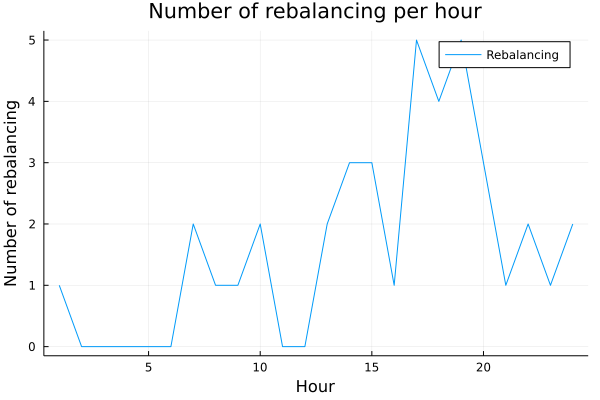

In [134]:
using Plots
plot([sum(x_1[:,:,:,i]) for i=1:24], label="Rebalancing", xlabel="Hour", ylabel="Number of rebalancing", title="Number of rebalancing per hour")

In [144]:
function export_results(z)
    z_nonzero = Tuple.(findall(x -> x != 0, z))[:,:]
    new=zeros(length(z_nonzero),5)
    for i=1:length(z_nonzero)
        indices=collect(z_nonzero[i])
        new[i,1:4]=indices # indices of rebalancing
        new[i,5]=z[indices] # nb of bikes
    end
    return new
end

export_results (generic function with 1 method)

In [145]:
function print_results(results)
    for i=1:length(results)
        println("Rebalancing from station ",results[i,1], " to ", results[i,2], "by van ", results[i,3], " at hour ", results[i,4]," of ", results[i,5]," bikes ")
    end
end

print_results (generic function with 1 method)

In [146]:
z_1_nonzero = Tuple.(findall(x -> x != 0, z_1))[:,:]
z_1[collect(z_1_nonzero[1])]

4-element Vector{Float64}:
  0.0
  0.0
  0.0
 -0.0

In [143]:
res_1=export_results(z_1)
print_results(res_1)

Rebalancing from station 11.0 to 22.0by van 4.0 at hour 1.0 of 0.0 bikes 
Rebalancing from station 3.0 to 26.0by van 3.0 at hour 7.0 of 0.0 bikes 
Rebalancing from station 3.0 to 27.0by van 5.0 at hour 7.0 of 0.0 bikes 
Rebalancing from station 49.0 to 45.0by van 4.0 at hour 8.0 of 0.0 bikes 
Rebalancing from station 43.0 to 24.0by van 2.0 at hour 9.0 of 0.0 bikes 
Rebalancing from station 2.0 to 25.0by van 1.0 at hour 10.0 of 0.0 bikes 
Rebalancing from station 49.0 to 23.0by van 4.0 at hour 10.0 of 0.0 bikes 
Rebalancing from station 33.0 to 2.0by van 1.0 at hour 13.0 of 0.0 bikes 
Rebalancing from station 25.0 to 2.0by van 4.0 at hour 13.0 of 0.0 bikes 
Rebalancing from station 2.0 to 33.0by van 1.0 at hour 14.0 of 0.0 bikes 
Rebalancing from station 4.0 to 31.0by van 2.0 at hour 14.0 of 0.0 bikes 
Rebalancing from station 2.0 to 33.0by van 5.0 at hour 14.0 of 0.0 bikes 
Rebalancing from station 33.0 to 15.0by van 2.0 at hour 15.0 of 0.0 bikes 
Rebalancing from station 42.0 to 4.0by

LoadError: BoundsError: attempt to access 39×5 Matrix{Float64} at index [40, 1]

## Dummy data

In [17]:
# capacity of stations
C = [10,10,10,10];

# d of stations
d = [[[0,10,0,5] [0,0,0,0] [0,5,0,0] [20,0,0,0]];;;
    [[0,0,0,0] [0,0,0,0] [30,0,0,0] [0,10,0,0]];;;
    [[0,0,0,5] [0,0,15,0] [0,0,0,0] [0,0,0,0]]];

# proximity of stations
X = [[0,1,1,1] [1,0,1,1] [1,1,0,1] [1,1,1,0]];

# capacity of stations
y0 = [6,2,4,3];

# number of vans
K = 2;

# capacity of vans
S = 20;

# distance of stations
D = [[0,0.5,1,0.5] [2,0,0.5,1] [0.5,1,0,0.5] [1,2,1,0]];

# number of stations
n_stations = 4;
n_hours=3;